Checking the counts of the images

In [4]:
import os

directory = "annotations" # directory where the txt files are located
files = os.listdir(directory) # get the list of all files in the directory

counts = []
for file in files:
    if file.endswith(".txt"): # check if the file is a txt file
        path = os.path.join(directory, file) # get the full path of the file
        with open(path, 'r') as f:
            num_rows = sum(1 for line in f) # count the number of rows in the file
            print(f"{file}: {num_rows}")
            counts.append(num_rows)

total_samples = sum(counts)
class_weights = np.array([total_samples / count for count in counts])
class_weights /= class_weights.sum() # normalize the weights to sum to 1
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print(f'example class init weights: {class_weights}')

night.txt: 598
people.txt: 6403
baby.txt: 95
female.txt: 3227
flower.txt: 761
car.txt: 319
portrait.txt: 3121
bird.txt: 360
clouds.txt: 1095
dog.txt: 448
male.txt: 2979
river.txt: 120
tree.txt: 525
sea.txt: 173
example class init weights: [0.04211008 0.00393282 0.26507189 0.00780348 0.03309045 0.0789399
 0.00806851 0.06994953 0.0229971  0.05620944 0.00845311 0.20984858
 0.04796539 0.14555971]


## Multi-class classifier

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
import torch.backends.mps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
import torchvision.transforms as transforms

import pandas as pd

In [28]:
#--- hyperparameters ---
N_EPOCHS = 10
LR = 0.01
DROPOUT_RATE = 0.3

#--- fixed constants ---
NUM_CLASSES = 14
DATA_DIR = 'dataset/%s'
NUM_CHANNELS = 3
WIDTH, HEIGHT = 128, 128
MEAN = [0.45183619, 0.4171191, 0.3778775 ]
SD = [0.24016619, 0.23024313, 0.22750713]

In [16]:
val_transform = transforms.Compose([
                                        #transforms.Grayscale(),
                                        #transforms.Resize(256),
                                        #transforms.CenterCrop(128),
                                        transforms.ToTensor()])
                                        #transforms.Normalize(MEAN, SD)])

test_transform = transforms.Compose([
                                        transforms.ToTensor()])#,
                                        #transforms.Normalize(MEAN, SD)])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomResizedCrop(size=128),
    transforms.ToTensor()#,
    #transforms.Normalize(MEAN, SD)
])


## V3

In [29]:
#def stratified_train_test_split(data, labels, test_size=0.2, random_state=42):
#    # Create a StratifiedShuffleSplit object and split the dataset into train and test
#    
#    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
#    train_val_indices, test_indices = next(sss.split(data, labels))
#    train_indices, val_indices = next(sss.split(train_val_indices, labels[train_val_indices]))
#
#
#    # Create train and test datasets from the indices generated by StratifiedShuffleSplit
#    train_dataset = Subset(dataset, train_indices)
#    test_dataset = Subset(dataset, test_indices)
#    val_dataset = Subset(dataset, val_indices)
#        
#    return train_dataset, test_dataset, val_dataset


#def stratified_train_test_split(dataset, test_size=0.2, random_state=42):
#    # Create a StratifiedShuffleSplit object and split the dataset into train and test
#    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
#    train_val_indices, test_indices = next(sss.split(dataset.image_paths, dataset.labels_df))
#    train_indices, val_indices = next(sss.split(train_val_indices, dataset.labels_df.iloc[train_val_indices]))
#
#    # Create train and test datasets from the indices generated by StratifiedShuffleSplit
#    train_dataset = Subset(dataset, train_indices)
#    test_dataset = Subset(dataset, test_indices)
#    val_dataset = Subset(dataset, val_indices)
#        
#    return train_dataset, test_dataset, val_dataset
#

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, alt_transform=None, skip_label='', min_samples_per_class=1500):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(os.path.join(self.root_dir, "images"))
        self.labels = {}
        for label in ['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']:
            if label in skip_label:
                continue
            with open(os.path.join(self.root_dir, "annotations", f"{label}.txt"), "r") as f:
                f.seek(0)
                self.labels[label] = set(f.read().splitlines())

        # Check the number of samples per class and augment data for the classes that have less than min_samples_per_class
        self.labels_df = pd.DataFrame(self.get_labels(), columns=self.labels.keys())
        #class_counts = self.labels_df.sum()
        #for index, (label, count) in enumerate(class_counts.items()):
        #    if count < min_samples_per_class:
        #        if alt_transform is not None:
        #            augmented_samples = self.augment_data(self.labels[label], alt_transform)
        #            #print(augmented_samples, self.labels[label])
        #            #print(f'union: {self.labels[label].union(augmented_samples)}')
        #            self.labels[label] = self.labels[label].union(augmented_samples)
        #            #print(f'adding: {augmented_samples}')
        #            #print(f'to {self.image_paths}')
        #            self.image_paths.extend([f"_{sample}_altered.jpg" for sample in augmented_samples])
        #print('After data augmentation:')
        #print('self.image_paths:', self.image_paths)
        #print('self.labels_df:', self.labels_df)

                
    #def augment_data(self, samples, transforms):
    #  augmented_samples = set()
    #  for sample in samples:
    #      image_path = os.path.join(self.root_dir, "images", f"im{sample}.jpg")
    #      image = Image.open(image_path).convert("RGB")
    #      for transform in transforms:
    #          transformed_image = transform(image)
    #          transformed_image_path = os.path.join(self.root_dir, "images", f"_{sample}_{transform.__class__.__name__}.jpg")
    #          transformed_image.save(transformed_image_path)
    #          #transformed_sample = transformed_image_path.split("/")[1]
    #          transformed_sample = int(os.path.basename(transformed_image_path)[1:].split("_")[0])
    #          #print(f'added: {transformed_sample}')
    #          augmented_samples.add(transformed_sample)
    #  return augmented_samples
                  
    def get_labels(self):
        labels = []
        for i in range(len(self)):
            image_path = os.path.join(self.root_dir, "images", self.image_paths[i])
            label = []
            for key, value in self.labels.items():
                filename = os.path.basename(image_path)[2:-4]
                label.append(1 if filename in value else 0)
            labels.append(label)
        return np.array(labels)
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, "images", self.image_paths[index])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels_df.iloc[index].values
        
        label = torch.tensor(label, dtype=torch.float32)
        
        return image, label, index, image_path



#skip_labels= ['baby', 'bird', 'car', 'clouds', 'dog', 'flower', 'night', 'river', 'sea', 'tree']
# Instantiate dataset
path = ""

dataset = CustomDataset(root_dir="")

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

#augmented_dataset = CustomDataset(root_dir="")
print('dataset loaded')
#dataset_merged = torch.utils.data.ConcatDataset([dataset, augmented_dataset])

# Split dataset into train and test using stratified sampling (+ validation)
#train_dataset, test_dataset, val_dataset = stratified_train_test_split(, test_size=0.2, random_state=42)
#train_aug_dataset, test_aug_dataset, val_aug_dataset = stratified_train_test_split(augmented_dataset, test_size=0.2, random_state=42)
#train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#train_dataset_merged = torch.utils.data.ConcatDataset([train_aug_dataset, train_dataset])
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

test_dataset.dataset.transform = test_transform
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create data loaders for each set
sampler = WeightedRandomSampler(class_weights_tensor, len(dataset))
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataset loaded


In [8]:
class MultiLabelClassifier(nn.Module):
    def __init__(self):
        super(MultiLabelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(NUM_CHANNELS, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
        self.drop = nn.Dropout(p=DROPOUT_RATE)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.drop(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ComplexMultiLabelClassifier(nn.Module):
    def __init__(self):
        super(ComplexMultiLabelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.drop1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU(inplace=True)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256, NUM_CLASSES)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.drop2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

class SimpleMultiLabelClassifier(nn.Module):
    def __init__(self):
        super(SimpleMultiLabelClassifier, self).__init__()
        self.conv = nn.Conv2d(NUM_CHANNELS, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 64 * 64, NUM_CLASSES)
        self.drop = nn.Dropout(p=DROPOUT_RATE)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv(x)))
        x = x.view(-1, 16 * 64 * 64)
        x = self.drop(x)
        x = self.fc(x)
        x = self.drop(x)
        return x

    
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        return torch.mean(focal_loss)

class FocalLossV2(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLossV2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)        


In [30]:
device = torch.device('cpu')

# set up device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        device = torch.device('mps')

print(device)

model = MultiLabelClassifier().to(device)

# Define loss function and optimizer
criterion = FocalLossV2(alpha=class_weights_tensor)
#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
optimizer = optim.Adam(model.parameters(), lr=LR)

# parameters for early stop
threshold = 4       # number of epochs to wait if test loss doesnt improve
min_loss = np.inf
counter = 0

# Train your model
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0
    total_zero = 0

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels, index, path = data
        #print(inputs.size())
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        # calculate accuracy
        predictions = (torch.sigmoid(outputs) > 0.5).int()
        correct = torch.eq(predictions, labels).sum().item()

        train_correct += correct

        # En oo iha varma miten tätä pitäs tulkita, atm laskee siis jokasen oikeen arvauksen ja yhen kuvan sisällä on käytännössä 14 arvausta
        train_total += labels.size(0)*NUM_CLASSES
        loss = criterion(outputs, labels)
        train_loss += loss
        loss.backward()
        optimizer.step()

        if predictions.sum() == 0:
            total_zero += 1

    # calculate average loss and accuracy for epoch
    epoch_loss = train_loss / len(train_loader)
    epoch_accuracy = train_correct / train_total
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy*100:.2f}%')
    print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

    model.eval()
    # evaluate model on validation set
    with torch.no_grad():
        val_loss = 0
        val_correct = 0
        val_total = 0
        total_zero = 0

        for i, data in enumerate(val_loader):
            inputs, labels, index, path = data
            inputs, labels = inputs.to(device), labels.to(device)
        
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            # calculate accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).int()
            correct = torch.eq(predictions, labels).sum().item()
            val_correct += correct

            val_total += labels.size(0)*NUM_CLASSES
            val_loss += loss

            if predictions.sum() == 0:
                total_zero += 1

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

    # early stopping
    if val_loss < min_loss:
        min_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= threshold:
            print(f'Stopping early after epoch {epoch}, best loss reached.')
            break
            

cpu
Epoch: 01
	Train Loss: 0.000 | Train Acc: 99.65%
	 Total Zero: 0  |  Zero Rate: 0.00%
	 Val. Loss: 0.043 |  Val. Acc: 90.19%
	 Total Zero: 0  |  Zero Rate: 0.00%
Epoch: 02
	Train Loss: 0.000 | Train Acc: 100.00%
	 Total Zero: 0  |  Zero Rate: 0.00%
	 Val. Loss: 0.044 |  Val. Acc: 90.19%
	 Total Zero: 0  |  Zero Rate: 0.00%


KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(), 'FocalAndAdamEpochs2.pth')

In [ ]:
model = MultiLabelClassifier().to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [25]:
#--- test ---
model.eval()
with torch.no_grad():
    test_loss = 0
    test_correct = 0
    test_total = 0
    total_zero = 0
    for i, data in enumerate(test_loader):
        inputs, labels, index, path = data
        inputs, labels = inputs.to(device), labels.to(device)
        #print(labels.shape)
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        # calculate accuracy
        predictions = (outputs > 0.5).int()
        
        correct = torch.eq(predictions, labels).sum().item()
        test_correct += correct

        test_total += labels.size(0)*NUM_CLASSES
        test_loss += loss

        if predictions.sum() == 0:
            total_zero += 1

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')
print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

Test Loss: 0.007 |  Test Acc: 92.55%
	 Total Zero: 63  |  Zero Rate: 100.00%


raw: tensor([[-0.3219, -0.0604, -0.6899, -0.0727, -0.0698, -0.3882, -0.2142, -0.0613,
          0.0767, -0.1483, -0.0794, -0.6138, -0.1242, -0.5281]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4202, 0.4849, 0.3341, 0.4818, 0.4826, 0.4042, 0.4467, 0.4847, 0.5192,
         0.4630, 0.4802, 0.3512, 0.4690, 0.3709]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


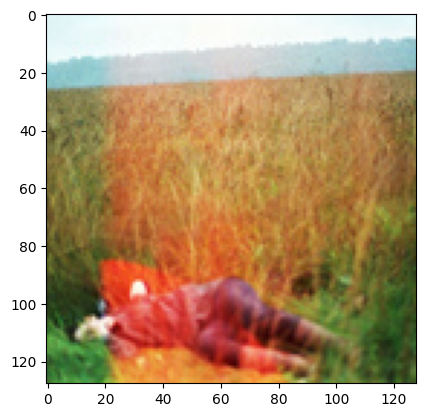

raw: tensor([[-0.3131, -0.0365, -0.6972, -0.0801, -0.0791, -0.3885, -0.2163, -0.0609,
          0.0745, -0.1394, -0.0882, -0.6121, -0.1370, -0.5302]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4224, 0.4909, 0.3324, 0.4800, 0.4802, 0.4041, 0.4461, 0.4848, 0.5186,
         0.4652, 0.4780, 0.3516, 0.4658, 0.3705]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


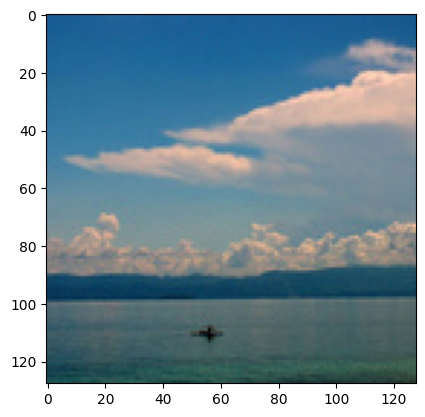

raw: tensor([[-0.3082, -0.0298, -0.6868, -0.0867, -0.0816, -0.3749, -0.2105, -0.0457,
          0.0682, -0.1420, -0.0851, -0.6139, -0.1308, -0.5327]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4235, 0.4925, 0.3347, 0.4783, 0.4796, 0.4074, 0.4476, 0.4886, 0.5170,
         0.4646, 0.4787, 0.3512, 0.4674, 0.3699]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


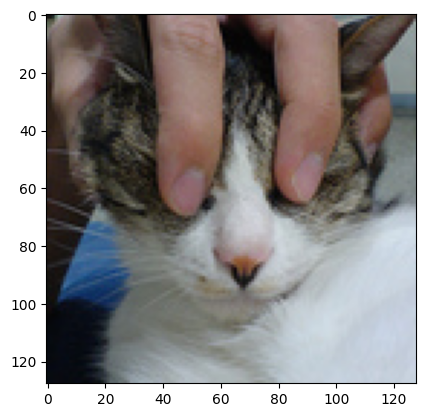

raw: tensor([[-0.3466, -0.0537, -0.7612, -0.0914, -0.0800, -0.4211, -0.2278, -0.0647,
          0.0949, -0.1584, -0.0850, -0.6909, -0.1398, -0.5862]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4142, 0.4866, 0.3184, 0.4772, 0.4800, 0.3962, 0.4433, 0.4838, 0.5237,
         0.4605, 0.4788, 0.3338, 0.4651, 0.3575]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


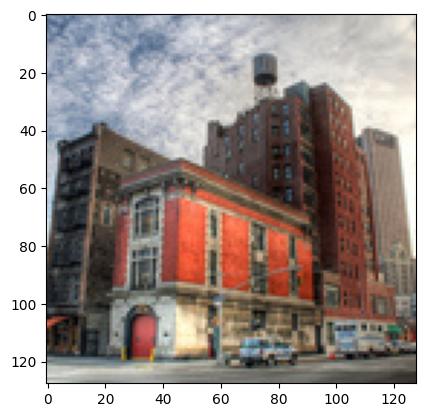

raw: tensor([[-0.4510, -0.0656, -1.0037, -0.1151, -0.0695, -0.5362, -0.2765, -0.1079,
          0.1323, -0.1952, -0.1007, -0.9433, -0.1830, -0.7740]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.3891, 0.4836, 0.2682, 0.4713, 0.4826, 0.3691, 0.4313, 0.4731, 0.5330,
         0.4513, 0.4748, 0.2802, 0.4544, 0.3156]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


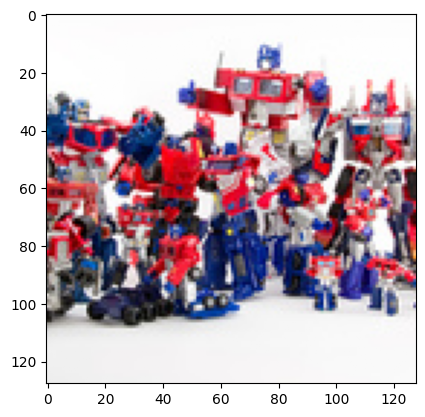

raw: tensor([[-0.2387, -0.0352, -0.5364, -0.0800, -0.0903, -0.3176, -0.1723, -0.0229,
          0.0258, -0.1107, -0.0799, -0.4554, -0.1075, -0.4257]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4406, 0.4912, 0.3690, 0.4800, 0.4774, 0.4213, 0.4570, 0.4943, 0.5064,
         0.4724, 0.4800, 0.3881, 0.4732, 0.3952]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


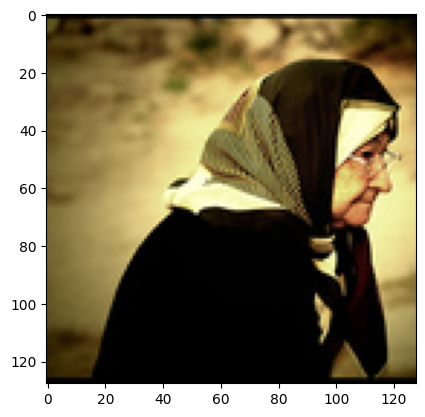

raw: tensor([[-0.3666, -0.0387, -0.7723, -0.0897, -0.0813, -0.4236, -0.2078, -0.0772,
          0.0946, -0.1634, -0.0847, -0.7024, -0.1641, -0.5964]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4094, 0.4903, 0.3160, 0.4776, 0.4797, 0.3957, 0.4482, 0.4807, 0.5236,
         0.4592, 0.4788, 0.3313, 0.4591, 0.3552]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


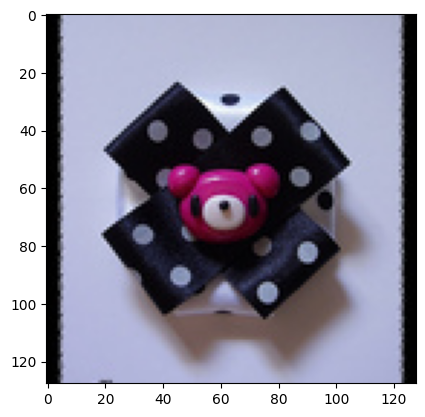

raw: tensor([[-0.3265, -0.0439, -0.7390, -0.0999, -0.0767, -0.4175, -0.2138, -0.0761,
          0.0710, -0.1371, -0.0842, -0.6692, -0.1442, -0.5752]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4191, 0.4890, 0.3232, 0.4750, 0.4808, 0.3971, 0.4468, 0.4810, 0.5177,
         0.4658, 0.4790, 0.3387, 0.4640, 0.3600]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


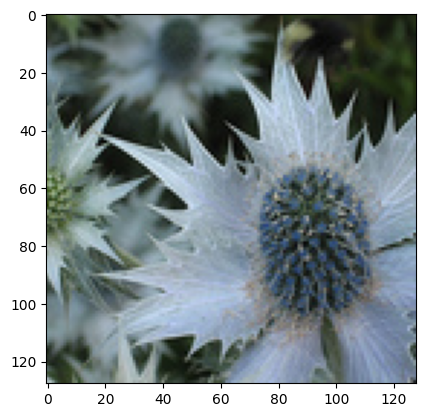

raw: tensor([[-0.2881, -0.0414, -0.6122, -0.0711, -0.0612, -0.3576, -0.2042, -0.0549,
          0.0557, -0.1299, -0.0748, -0.5495, -0.1135, -0.4775]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4285, 0.4897, 0.3516, 0.4822, 0.4847, 0.4115, 0.4491, 0.4863, 0.5139,
         0.4676, 0.4813, 0.3660, 0.4717, 0.3829]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


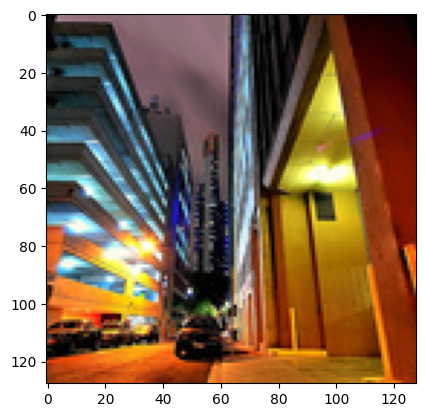

raw: tensor([[-0.2424, -0.0514, -0.5383, -0.0638, -0.0612, -0.3180, -0.1809, -0.0342,
          0.0274, -0.1112, -0.0755, -0.4677, -0.0977, -0.4244]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4397, 0.4872, 0.3686, 0.4840, 0.4847, 0.4212, 0.4549, 0.4915, 0.5069,
         0.4722, 0.4811, 0.3852, 0.4756, 0.3955]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


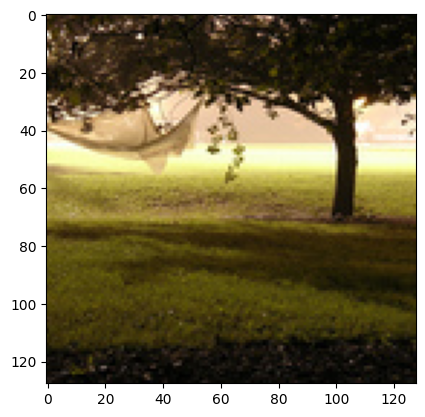

raw: tensor([[-0.2927, -0.0529, -0.6732, -0.0925, -0.0777, -0.3814, -0.2204, -0.0440,
          0.0662, -0.1459, -0.0795, -0.6000, -0.1198, -0.5248]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4273, 0.4868, 0.3378, 0.4769, 0.4806, 0.4058, 0.4451, 0.4890, 0.5165,
         0.4636, 0.4801, 0.3543, 0.4701, 0.3717]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


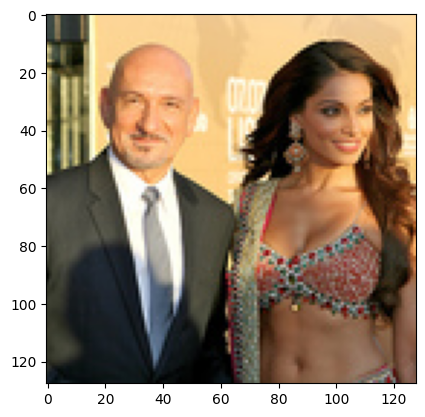

raw: tensor([[-0.4420, -0.0490, -0.9890, -0.1204, -0.0773, -0.5343, -0.2713, -0.1010,
          0.1456, -0.1876, -0.0950, -0.9213, -0.1879, -0.7606]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.3913, 0.4877, 0.2711, 0.4699, 0.4807, 0.3695, 0.4326, 0.4748, 0.5363,
         0.4532, 0.4763, 0.2847, 0.4532, 0.3185]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


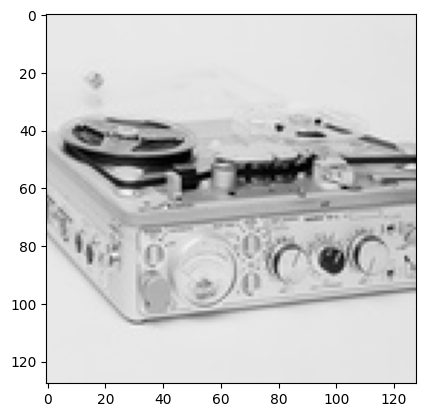

raw: tensor([[-0.2512, -0.0382, -0.5950, -0.0643, -0.0651, -0.3511, -0.2050, -0.0462,
          0.0281, -0.1184, -0.0805, -0.5219, -0.1035, -0.4630]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4375, 0.4904, 0.3555, 0.4839, 0.4837, 0.4131, 0.4489, 0.4885, 0.5070,
         0.4704, 0.4799, 0.3724, 0.4742, 0.3863]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


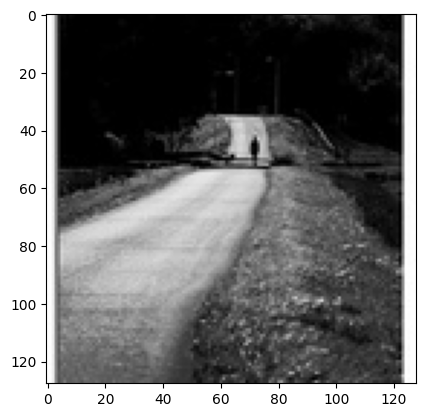

raw: tensor([[-0.2592, -0.0590, -0.5698, -0.0544, -0.0625, -0.3259, -0.1841, -0.0451,
          0.0594, -0.1154, -0.0663, -0.4924, -0.0972, -0.4544]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4356, 0.4853, 0.3613, 0.4864, 0.4844, 0.4192, 0.4541, 0.4887, 0.5149,
         0.4712, 0.4834, 0.3793, 0.4757, 0.3883]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


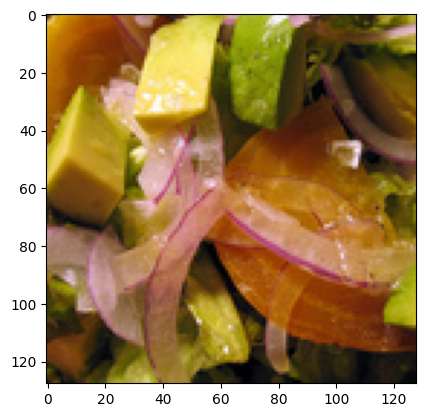

raw: tensor([[-0.3682, -0.0563, -0.8244, -0.0871, -0.0632, -0.4496, -0.2489, -0.0913,
          0.1096, -0.1595, -0.0765, -0.7433, -0.1511, -0.6285]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4090, 0.4859, 0.3048, 0.4782, 0.4842, 0.3894, 0.4381, 0.4772, 0.5274,
         0.4602, 0.4809, 0.3223, 0.4623, 0.3478]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


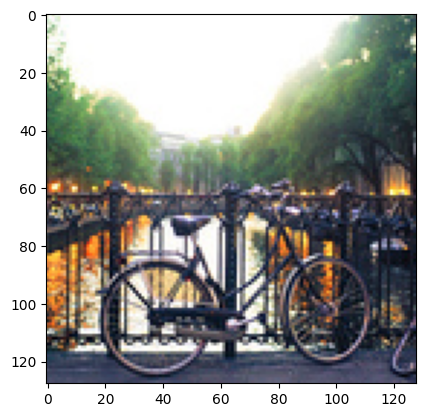

raw: tensor([[-0.2816, -0.0484, -0.6294, -0.0703, -0.0774, -0.3483, -0.1904, -0.0505,
          0.0517, -0.1273, -0.0767, -0.5475, -0.1079, -0.4890]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4301, 0.4879, 0.3477, 0.4824, 0.4807, 0.4138, 0.4525, 0.4874, 0.5129,
         0.4682, 0.4808, 0.3665, 0.4731, 0.3801]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


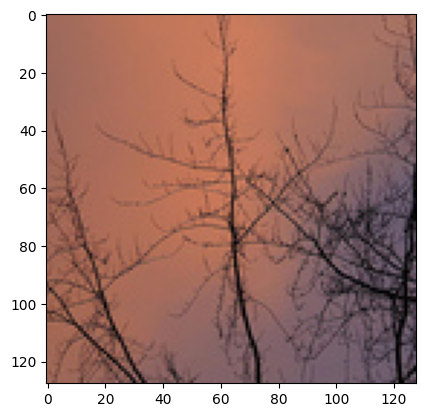

raw: tensor([[-0.2999, -0.0530, -0.6818, -0.0705, -0.0798, -0.3754, -0.2027, -0.0442,
          0.0640, -0.1322, -0.0852, -0.6126, -0.1206, -0.5159]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4256, 0.4868, 0.3359, 0.4824, 0.4801, 0.4072, 0.4495, 0.4889, 0.5160,
         0.4670, 0.4787, 0.3515, 0.4699, 0.3738]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


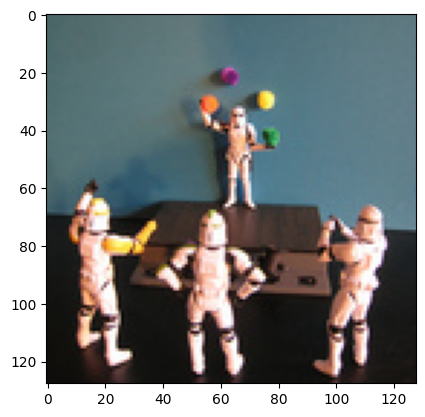

raw: tensor([[-0.2284, -0.0506, -0.4758, -0.0630, -0.0682, -0.2909, -0.1575, -0.0142,
          0.0376, -0.1054, -0.0574, -0.4034, -0.0857, -0.3586]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4432, 0.4874, 0.3832, 0.4843, 0.4830, 0.4278, 0.4607, 0.4964, 0.5094,
         0.4737, 0.4857, 0.4005, 0.4786, 0.4113]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


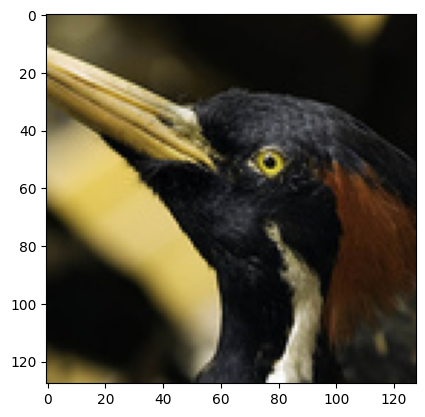

raw: tensor([[-0.2406, -0.0428, -0.5224, -0.0620, -0.0690, -0.2932, -0.1745, -0.0304,
          0.0314, -0.1084, -0.0686, -0.4360, -0.0967, -0.4098]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4402, 0.4893, 0.3723, 0.4845, 0.4828, 0.4272, 0.4565, 0.4924, 0.5078,
         0.4729, 0.4829, 0.3927, 0.4758, 0.3990]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


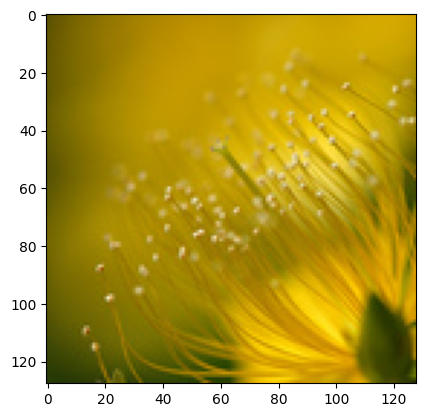

raw: tensor([[-0.2348, -0.0429, -0.5039, -0.0647, -0.0749, -0.2797, -0.1599, -0.0249,
          0.0216, -0.1062, -0.0766, -0.4220, -0.0963, -0.3981]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4416, 0.4893, 0.3766, 0.4838, 0.4813, 0.4305, 0.4601, 0.4938, 0.5054,
         0.4735, 0.4809, 0.3960, 0.4759, 0.4018]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


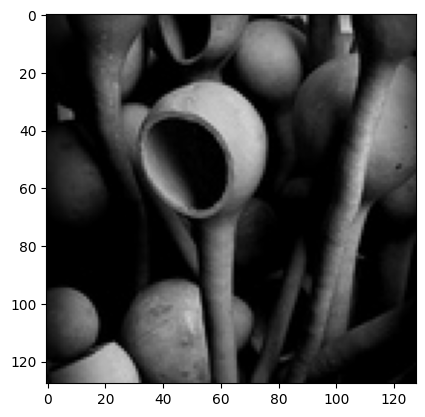

raw: tensor([[-0.2771, -0.0494, -0.6587, -0.0876, -0.0826, -0.3700, -0.2008, -0.0480,
          0.0509, -0.1447, -0.0801, -0.5642, -0.1138, -0.5169]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4312, 0.4877, 0.3410, 0.4781, 0.4794, 0.4085, 0.4500, 0.4880, 0.5127,
         0.4639, 0.4800, 0.3626, 0.4716, 0.3736]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


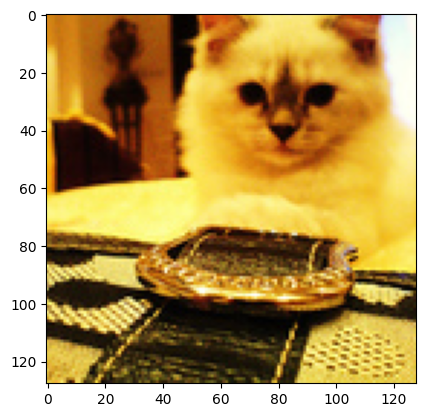

raw: tensor([[-0.1847, -0.0397, -0.3944, -0.0422, -0.0710, -0.2342, -0.1498, -0.0110,
         -0.0017, -0.0849, -0.0686, -0.2997, -0.0682, -0.3187]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4540, 0.4901, 0.4027, 0.4895, 0.4823, 0.4417, 0.4626, 0.4972, 0.4996,
         0.4788, 0.4829, 0.4256, 0.4830, 0.4210]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


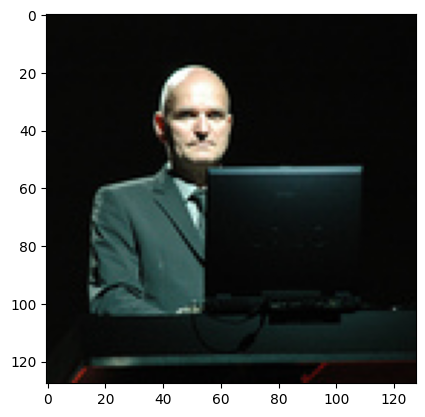

raw: tensor([[-0.3815, -0.0576, -0.8279, -0.0920, -0.0896, -0.4620, -0.2154, -0.0893,
          0.0864, -0.1592, -0.0947, -0.7447, -0.1517, -0.6402]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4058, 0.4856, 0.3041, 0.4770, 0.4776, 0.3865, 0.4464, 0.4777, 0.5216,
         0.4603, 0.4763, 0.3220, 0.4621, 0.3452]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


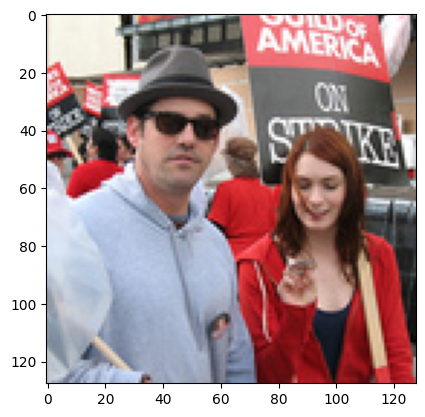

raw: tensor([[-0.2607, -0.0404, -0.5826, -0.0679, -0.0784, -0.3212, -0.1878, -0.0325,
          0.0472, -0.1104, -0.0701, -0.4981, -0.1065, -0.4535]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4352, 0.4899, 0.3583, 0.4830, 0.4804, 0.4204, 0.4532, 0.4919, 0.5118,
         0.4724, 0.4825, 0.3780, 0.4734, 0.3885]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


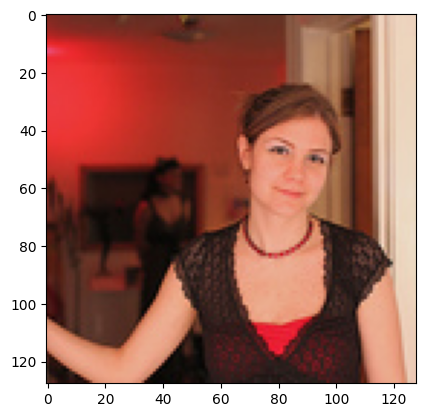

raw: tensor([[-0.3848, -0.0445, -0.8329, -0.1050, -0.0630, -0.4563, -0.2421, -0.0933,
          0.1036, -0.1765, -0.0928, -0.7756, -0.1600, -0.6484]],
       grad_fn=<AddmmBackward0>), sigmoid: tensor([[0.4050, 0.4889, 0.3030, 0.4738, 0.4843, 0.3879, 0.4398, 0.4767, 0.5259,
         0.4560, 0.4768, 0.3153, 0.4601, 0.3433]], grad_fn=<SigmoidBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)


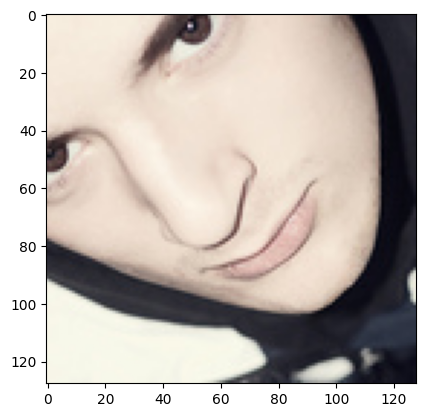

In [26]:
def testN(num_pics):
    test_total = 0
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    for i, data in enumerate(test_loader):
        test_total += 1
        if test_total > num_pics:
            break
        input, label, index, path = data
        input, label = input.to(device), label.to(device)
        output = model.forward(input)
        predictions = (torch.sigmoid(output) > 0.5).int()
        print(f'raw: {output}, sigmoid: {torch.sigmoid(output)}')
        print(['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree'])
        print('label',label)
        print()
        print('pred', predictions)

        image_array = input.numpy()
        plt.imshow(image_array.transpose((2, 3, 1, 0)).squeeze(3))
        plt.show()


testN(25)